Padé approximation
==========

Padé approximation is an extension of the concept of Taylor approximation with rational functions rather than polynomials. The basic premise is that the approximation is made by matching derivatives at a particular point.

In [1]:
import sympy
sympy.init_printing()
%matplotlib inline

In [2]:
import numpy

In [3]:
a, b, c, s, D = sympy.symbols('a, b, c, s, D')

We will approximate a Laplace dead time

In [4]:
G = sympy.exp(-2*s)
G

by a 1/1 Padé approximation. This means first order above the line and first order below. In order to force uniqueness of the solution, we force the constant term in the denominator to be unity.

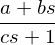

In [5]:
ga = (a + b*s)/(1 + c*s)
ga

We can solve for the parameters by setting the function value, first derivative and second derivative of the original function and the approximation to be equal at $s=0$.

In [6]:
s0 = 0
soln = sympy.solve([(G - ga).subs({s: s0}),
                    (G - ga).diff(s).subs({s: s0}),
                    (G - ga).diff(s, 2).subs({s: s0})], [a, b, c], dict=True)
soln

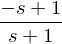

In [7]:
G_pade = ga.subs(soln[0])
G_pade

Compare this with a taylor approximation with same number of coefficients (matching the same number of derivatives)

In [8]:
G_taylor = G.series(s, s0, 3).removeO()
G_taylor

So how much do the approximations resemble the original function?

First, let's check just the real part

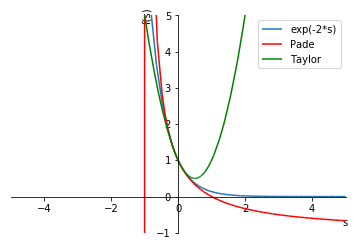

In [9]:
plotrange = (s, -5, 5)
def plot_approx(G, G_pade, G_taylor):
    p = sympy.plot(G, plotrange, show=False)
    pade_approx = sympy.plot(G_pade, plotrange, show=False, line_color='red')
    taylor_approx = sympy.plot(G_taylor, plotrange, show=False, line_color='green')
    p.extend(pade_approx)
    p.extend(taylor_approx)
    p[1].label = 'Pade'
    p[2].label = 'Taylor'
    p.ylim = (-1, 5)
    p.legend = True
    p.show()
plot_approx(G, G_pade, G_taylor)

Note the singularity in the Padé approximation, as well as the fact that the Taylor polynomial has an unbounded error to the right, while the Padé approximation is better behaved.

Now, let's see what this looks like for the whole complex plane

In [10]:
def cplot(G):
    f = sympy.lambdify(s, G, ['mpmath', 'numpy'])
    sympy.mpmath.cplot(f, [-5, 5], [-5, 5])

The original function

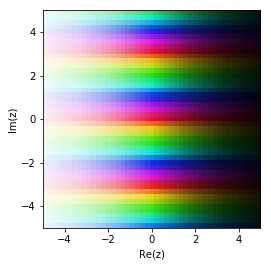

In [11]:
cplot(G)

Pade approximation

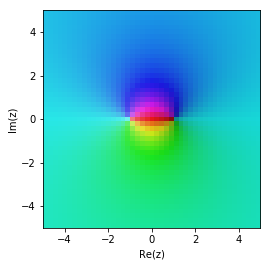

In [12]:
cplot(G_pade)

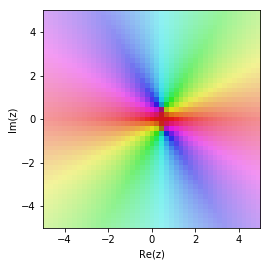

In [13]:
cplot(G_taylor)

Generalised function
=============

We can generalise the solution procedure to an arbitrary number of parameters

In [14]:
def series_var(varname, N):
    """ Produce a series of variables with numeric subscripts """
    return sympy.symbols(' '.join('{}_{}'.format(varname, index) for index in range(N)))

In [15]:
def pade(G, M, N, p=0):
    """ Return a Padé approximation of the function G, of order M/N around point p"""
    M += 1
    N += 1
    a = series_var('a', N)
    b = series_var('b', M)
    approximation = sum(b[i]*s**i for i in range(M))/sum(a[i]*s**i for i in range(N))
    nder = M + N
    equations = [(G - approximation).diff(s, i).subs({s: p}) 
                 for i in range(nder-1)] + [a[0] - 1]
    pars = sympy.solve(equations, a + b, dict=True)
    return approximation.subs(pars[0])

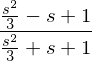

In [16]:
pade(G, 2, 2, 0)

In [17]:
def approx_comparison(M, N):
    plot_approx(G, pade(G, M, N, 0), sympy.series(G, s, 0, N+M+1).removeO())

In [18]:
from ipywidgets import interact

In [19]:
interact(approx_comparison, N=(1, 3), M=(1, 3))

<function __main__.approx_comparison>